# Chapter 2 : End-To-End Machine Learning Project

### Our approach for this problem will be based below main steps-

1. Look at the bigger picture
2. Get the data
3. Explore & visualise the data to gain insights
4. Prepare the data for machine learning algorithms
5. Select a model & train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor & maintain your system

In [62]:
# import statements
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import randint
%matplotlib inline

## 2. Get the Data

In [2]:
data_path = os.path.join(os.getcwd(), "housing.csv")

In [3]:
data_path

'/Users/n1579399/Desktop/my-datascience-learnings/books/hands-on-ml-3/chapter2/housing/housing.csv'

In [4]:
housing_df = pd.read_csv(data_path)
housing_df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice feature 'total_bedrooms' has only 20433 out of total dataset entries 20640. Meaning 207 districts does not have valid value for this feature.

### Exploring 'ocean_proximity' as categorical feature: 5 categorical values as below

In [6]:
housing_df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

### Exploring the distribution of numerical attributes
- Numerical features are pretty skewed, we need may need to normalise them
- Few features like housing_median_age & median_house_value are capped at different levels

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

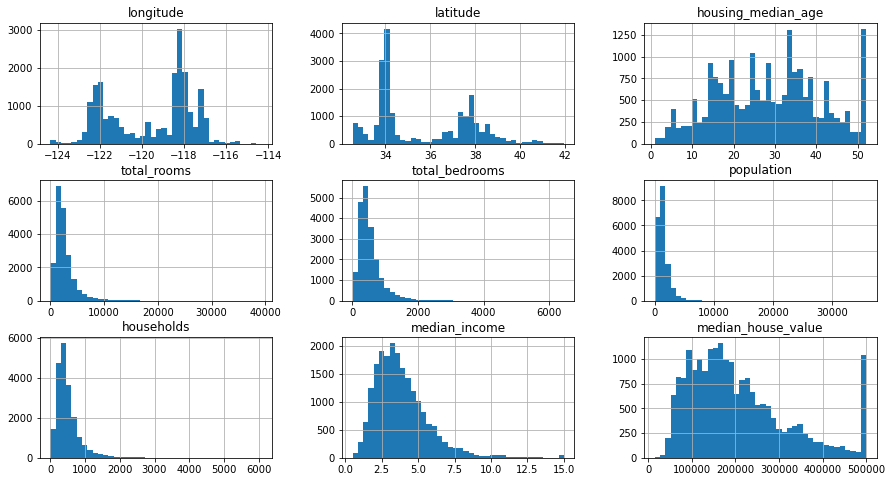

In [7]:
housing_df.hist(figsize=(15,8), bins=40) 
# figsize = how stretch the figure will be
# bins = how smooth the distribution looks like, divide data into smaller bins

### Creating a Test Set

- Here we have randomly selected the test set which is not the ideal way because it might introduce the sampling bias. Test set should be the representative of all the dataset to produce reliable & accurate results.
- Assuming 'median_income' feature is very important in predicting 'median_house_value' so the test set should be representative of this feature.
- Looking at 'median_income', it appears to be divided mostly from 1.5 to 6. Let's create new feature 'income_cat'to represent categories for this continous variable. Categories shouldn't be too large or small
- pd.cut() function provides the way to create these categories
- train_test_split() function provides an argument stratify=feature_name which is used to create test set with stratified strategy

In [8]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],
                                 bins=[0.,1.5,3.,4.5,6., np.inf],
                                 labels=[1,2,3,4,5]) # np.inf required as bins should > labels

Text(0, 0.5, 'Number of districts')

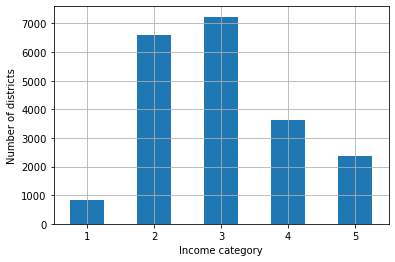

In [9]:
housing_df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True) # rot: 
plt.xlabel("Income category")
plt.ylabel("Number of districts")

In [10]:
# unstratified data
unstrat_train_set, unstrat_test_set = train_test_split(housing_df, test_size=0.2, random_state=42)

In [11]:
# stratified sampling
strat_train_set, strat_test_set = train_test_split(housing_df, test_size=0.2, random_state=42, stratify=housing_df["income_cat"])

In [12]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set) # total strat test set = 4128


income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [13]:
# we won't use the income_cat feature again & also don't want it to influence our predictions, so we will remove it
for feat_set in (strat_train_set, strat_test_set):
    feat_set.drop("income_cat", axis=1, inplace=True)

## 3. Explore & Visualise the Data to Gain Insights

In [14]:
# Lets' copy the original data to analyse/manipulate

housing = strat_train_set.copy()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

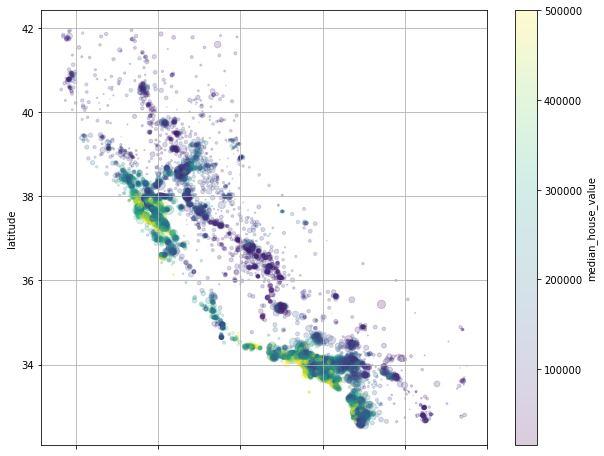

In [15]:
# As we are dealing with geographical data so it make sense to plot the scatterplot

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2,
            grid=True, s=housing["population"]/100, 
              c="median_house_value",
            figsize=(10,8)) # alpha represents high density areas

### Correlations of attributes

In [16]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [17]:
corr_matrix = housing.corr(numeric_only=True) # corr method uses Pearson' coefficient

In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

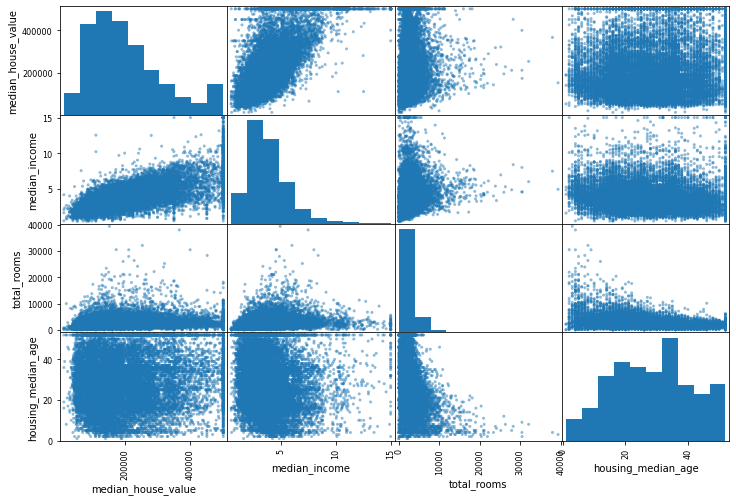

In [19]:
# Another way to look the correlations between numerical attributes is scatter plots
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()
# only promising attribute to predict median_house_value would be median_income

### Experiment with Attribute Combinations

In [20]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

In [21]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
 10  rooms_per_house     16512 non-null  float64
 11  bedrooms_ratio      16344 non-null  float64
 12  people_per_house    16512 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.8+ MB


In [22]:
corr_matrix = housing.corr(numeric_only=True)

In [23]:
# here bedrooms_ratio is negatively correlated to median_house_value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

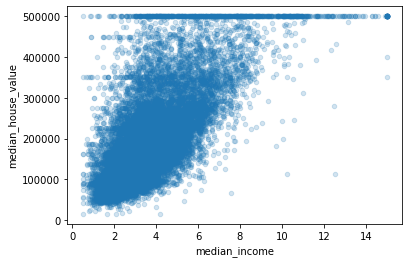

In [24]:
# lets zoom in with median_income
housing.plot(kind="scatter",x="median_income", y="median_house_value",alpha=0.2)

In [25]:
# removing the predictors from data
housing = strat_train_set.drop("median_house_value", axis=1) # axis = 1 means transform via columns
housing_labels = strat_train_set["median_house_value"].copy()

# adding the numeric features again to housing dataframe
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

### Clean the Data
- Most ML algorithms won't work on missing data so we need to handle this data
- Its good idea to use imputer from sklearn
    - You can apply the transformation on all the data simultanously like train, test, validation
    - It stores the missing value strategy (for example, median) for all the features and for incoming data
    - Imputer saves the result into its 'statistics_' attribute

In [26]:
# Median can only work with numeric data features
imputer = SimpleImputer(strategy="median")

In [27]:
# dataframe with numeric only features
housing_num = housing.select_dtypes(include=[np.number])

In [28]:
housing_num.info() # total_bedrooms have null values

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   rooms_per_house     16512 non-null  float64
 9   bedrooms_ratio      16344 non-null  float64
 10  people_per_house    16512 non-null  float64
dtypes: float64(11)
memory usage: 1.5 MB


In [29]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
# imputer saves the result in its 'statistics_' instance. Showing median for all 8 numeric features
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12500000e+03,
        4.34000000e+02,  1.16700000e+03,  4.08000000e+02,  3.53850000e+00,
        5.23557310e+00,  2.03105786e-01,  2.82231619e+00])

In [31]:
# now using this trained imputer to transform the values in training set
housing_imputed = imputer.transform(housing_num)

In [32]:
print(housing_imputed, type(housing_imputed))

[[-122.42         37.8          52.         ...    3.21179884
     0.33574225    1.52417795]
 [-118.38         34.14         40.         ...    5.50420168
     0.18015267    1.86554622]
 [-121.98         38.36         33.         ...    5.33497537
     0.20036934    2.76847291]
 ...
 [-117.06         32.59         13.         ...    5.15789474
     0.19770408    3.70263158]
 [-118.4          34.06         37.         ...    4.51193317
     0.2308913     2.05847255]
 [-122.41         37.66         44.         ...    2.03301887
     0.45243619    3.21698113]] <class 'numpy.ndarray'>


In [33]:
# creating dataframe from numpy array which is the output of transformer
housing_tr = pd.DataFrame(housing_imputed, columns=housing_num.columns, index=housing_num.index)

In [34]:
# There are no null values left
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   rooms_per_house     16512 non-null  float64
 9   bedrooms_ratio      16512 non-null  float64
 10  people_per_house    16512 non-null  float64
dtypes: float64(11)
memory usage: 1.5 MB


### Handling categorical attributes
- Currently we only have the 'ocean_proximity' attribute as categorical
- Simple way is to use OrdinalEncoder but the problem with this approach is it creates importance within nearer values. For example, categorised 1,2,3 values works with categories like good, better, excellent etc but not with ocean_proximity.
- Better and common solution is to use one hot encoding where each category creates an attribute with 1(hot) or 0 (cold) values

In [35]:
housing_cat = housing[["ocean_proximity"]] # housing["ocean_proximity"] -> series, housing[["ocean_proximity"]] -> dataframe(housing_cat)

housing_cat.head(5)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [36]:
cat_encoder = OneHotEncoder()

In [37]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Scaling & transformation

- Machine learning algorithms don't perform well if the features are not scaled properly. For example, median_income range from 0-15 and total number of rooms range from 6 to 39320. In this case the algorithm will be baised towards 'total num of rooms' feature.
- sklearn provides MinMaxScaling, StandardScaler options to scale numeric features. MinMaxScaling squeeze feature values from 0 to 1 while StandardScaler substract mean & divide by standard deviation
- rbf kernels are radial basis function

In [39]:
minmax_scalar = MinMaxScaler()
housing_minmax = minmax_scalar.fit_transform(housing_num)
housing_minmax

array([[0.19574037, 0.55851064, 1.        , ..., 0.01647218, 0.26193583,
        0.00165787],
       [0.60547667, 0.16914894, 0.76470588, ..., 0.03272803, 0.08905852,
        0.0023382 ],
       [0.24036511, 0.61808511, 0.62745098, ..., 0.03152801, 0.11152149,
        0.00413769],
       ...,
       [0.73935091, 0.00425532, 0.23529412, ..., 0.0302723 , 0.10856009,
        0.00599942],
       [0.60344828, 0.1606383 , 0.70588235, ..., 0.02569167, 0.14543478,
        0.0027227 ],
       [0.19675456, 0.54361702, 0.84313725, ..., 0.00811323, 0.39159577,
        0.00503154]])

In [40]:
std_scalar = StandardScaler()
housing_std_scalar = std_scalar.fit_transform(housing_num)
housing_std_scalar

array([[-1.42303652,  1.0136059 ,  1.86111875, ..., -0.86602737,
         2.14135179, -0.33020372],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.0245495 ,
        -0.56854491, -0.25361631],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.04119332,
        -0.21643202, -0.05104091],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ..., -0.10998748,
        -0.26285278,  0.15854151],
       [ 0.58639727, -0.73960483,  0.66925745, ..., -0.36093745,
         0.3151675 , -0.21033248],
       [-1.41803793,  0.94797769,  1.22545939, ..., -1.32397227,
         4.1738051 ,  0.04958379]])

In [41]:
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

### Transformation Pipeline

- sklearn provides a great functionality of transformers to create pipelines of functions
- transformers can be used to hook multiple preprocessing steps into one. Output of one step will feed into as input of next one and so on

In [42]:
# lets create a pipeline which handles numeric features - imputation & scaling
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [43]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)

In [44]:
# this is ndarray
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94, -0.87,
         2.15, -0.33],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17,  0.02,
        -0.57, -0.25]])

In [45]:
# name of columns
num_attributes = list(num_pipeline.get_feature_names_out())
num_attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_house',
 'bedrooms_ratio',
 'people_per_house']

In [46]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

In [47]:
df_housing_num_prepared.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,people_per_house
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,-0.866027,2.153743,-0.330204
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.024550,-0.569651,-0.253616
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,-0.041193,-0.215784,-0.051041
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,-0.034858,-0.154314,-0.141475
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,-0.666554,1.132023,-0.306148


In [48]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

In [49]:
cat_attributes = list(housing_cat.columns)
cat_attributes

['ocean_proximity']

In [50]:
# similarly create a pipeline which handles categorical values - imputation & onehotencoding
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

In [51]:
# lets combine numeric & categorical features into one

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes)
])

# instead of above approach you can do following steps to get the same output with much ease
# preprocessing = make_column_transformer(num_pipeline, make_column_selector(dtype_include=np.number),
#                                        cat_pipeline, make_column_selector(dtype_include=object))

In [52]:

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared[:5].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94, -0.87,
         2.15, -0.33,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17,  0.02,
        -0.57, -0.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76, -0.04,
        -0.22, -0.05,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 1.23, -0.88, -0.92,  0.7 ,  0.74,  0.38,  0.73, -0.85, -0.03,
        -0.15, -0.14,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.71, -0.88,  0.59,  0.79,  1.6 ,  0.44,  1.76, -0.18, -0.67,
         1.13, -0.31,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

In [53]:
housing_prepared.shape

(16512, 16)

In [54]:
preprocessing.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income', 'num__rooms_per_house',
       'num__bedrooms_ratio', 'num__people_per_house',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

#### You can combine all preprocessing steps into one column transformer

In [55]:
preprocessing_df = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out())

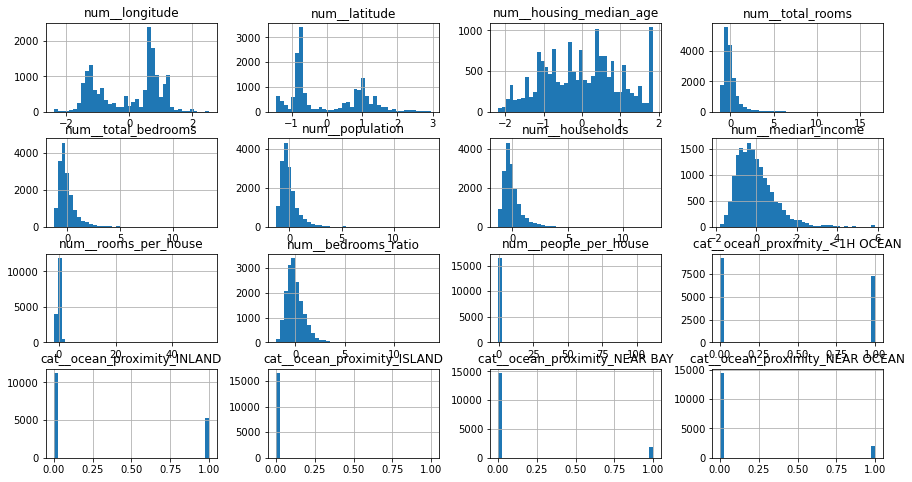

In [56]:
preprocessing_df.hist(figsize=(15,8), bins=40);

## Select and Train Model

In [57]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmse = -cross_val_score(forest_reg, housing, housing_labels, scoring = "neg_root_mean_squared_error", cv=10)

In [58]:
pd.Series(forest_rmse).describe()

count       10.000000
mean     49589.906553
std       1024.652290
min      47632.695679
25%      48996.670026
50%      49826.201020
75%      50095.541669
max      51350.776582
dtype: float64

## Fine-Tune The Model

RandomisedSearchCV
GridSearchCV

In [80]:
full_pipeline = Pipeline([("preprocessing", preprocessing),
                         ("random_forest", RandomForestRegressor(random_state=42)),
                         ])

In [86]:
param_distribs = {
    "preprocessing": randint(low=3, high=50),
    "random_forest": randint(low=2, high=20)
}

In [87]:
rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
                               scoring="neg_root_mean_squared_error", random_state=42, error_score='raise')

In [88]:
rnd_search.fit(housing, housing_labels)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' '41' (type <class 'int'>) doesn't